In [15]:
import pandas as pd
import statsmodels.api as sm
import numpy as np  # numpy 임포트 필요

# 1. 데이터 불러오기
try:
    data = pd.read_csv("/Users/lavi/MLDL_25_2_ASSIGNMENT/ASSIGNMENT_2/Data/CarPrice.csv")
except FileNotFoundError:
    print("CarPrice.csv 파일을 찾을 수 없습니다. 파일 경로를 확인하세요.")
    # 파일이 없으면 더 이상 진행하지 않음


# 2. 데이터 전처리
# 종속 변수(y) 및 독립 변수(X) 분리
y = data['price']

# X에서 불필요한 변수 제거 (car_ID: 단순 식별자, CarName: 카디널리티가 너무 높아 모델에 부정적 영향, price: 종속 변수)
X = data.drop(['price', 'car_ID', 'CarName'], axis=1)


#Alogirthm
# [1: 'object' 타입의 숫자형 변수 수동 변환]
# 'doornumber'와 'cylindernumber'는 순서가 있는 수치형 변수이므로 직접 매핑.
num_map = {
    'two': 2, 'three': 3, 'four': 4, 'five': 5,
    'six': 6, 'eight': 8, 'twelve': 12
}
# .map()을 사용하면 매핑되지 않은 값(예: NaN)이 발생할 수 있으나,
# 뒤따르는 fillna()에서 처리되므로 안전합니다.
X['doornumber'] = X['doornumber'].map(num_map)
X['cylindernumber'] = X['cylindernumber'].map(num_map)


# 3. 범주형 변수 원-핫 인코딩
# 이제 X에 남은 'object' 타입은 실제 범주형 변수들임 (예: fueltype, carbody)
X_processed = pd.get_dummies(X, drop_first=True)


# [2: '?'와 같은 문자열로 인해 'object'가 된 숫자 열 처리]
# X_processed의 모든 열을 강제로 숫자형으로 변환합니다.
# 변환할 수 없는 값(예: '?')은 'coerce' 옵션으로 NaN (Not a Number)이 됩니다.
# 이 단계가 핵심임.
for col in X_processed.columns:
    X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')


# [3: NaN 값 처리]
# statsmodels는 NaN 값을 허용하지 않는다.
# pd.to_numeric(errors='coerce')로 인해 생긴 NaN 값이나,
# 수동 매핑(num_map)에서 변환되지 못한 NaN 값들을 각 열의 '평균값'으로 대체하여 대입함.
X_processed = X_processed.fillna(X_processed.mean())

# 이제 X_processed는 모든 열이 숫자형(float)이고 NaN 값이 없음.


# 4. 절편(Intercept) 추가
# statsmodels는 sklearn과 달리 수동으로 절편(상수항)을 추가해야 함
X_with_const = sm.add_constant(X_processed)

# [수정 4: 최종 데이터 타입 확인]
# OLS에 입력하기 전, 모든 데이터 타입을 float으로 명확하게 지정함.
X_with_const = X_with_const.astype(float)


# 5. 모델 적합 (Baseline Multiple Linear Regression)
# OLS (Ordinary Least Squares) 모델 학습
model = sm.OLS(y, X_with_const)
results = model.fit()


# 6. 결과 보고 및 해석
print("--- [ 1.(a) 문제 보고서 ] ---")
print("\n[보고 항목 1: 절편 및 표준화 여부]")
print("1. 절편(Intercept) 포함 여부: Yes; 모델에 절편을 포함.")
print("2. 예측 변수 표준화 여부: No; 기본 다중 선형 회귀 모델에서는 표준화를 적용하지 않음.")

print("\n[보고 항목 2: 정규화 모델에서 표준화가 중요한 이유]")
print(
    "릿지(Ridge)와 라쏘(Lasso) 같은 정규화 회귀는 계수(beta)의 크기 자체에 페널티를 부과하는 방법이다.\n"
    "만약 예측 변수들이 서로 다른 스케일(예: 'horsepower' (50~200) vs 'boreratio' (2~4))을 갖는다면,\n"
    "스케일이 큰 변수의 계수가 스케일이 작은 변수의 계수보다 불공평하게 더 큰 페널티를 받는다.\n"
    "이는 모델이 변수의 중요도가 아닌 스케일에 의존하여 계수를 축소하게 만든다.\n"
    "따라서, 모든 변수가 페널티 항에 동등하게 기여하도록 만들기 위해 (Z-score 표준화 등으로)\n"
    "데이터의 스케일을 통일(평균 0, 분산 1)하는 표준화 전처리가 필수적이다."
)

print("\n[보고 항목 3: 계수, 유의미한 계수, 훈련 R^2]")

r_squared = results.rsquared
all_coefficients = results.params
p_values = results.pvalues

# 유의수준 (p<0.05) 기준
significant_coefficients = all_coefficients[p_values < 0.05]

print(f"\n1. 훈련 데이터 R^2 (Training R-squared): {r_squared:.4f}")

print("\n2. 추정된 모든 계수 (절편 포함):")
print(all_coefficients.to_string())

print("\n3. 통계적으로 유의미한 계수 (p < 0.05):")
if significant_coefficients.empty:
    print("유의미한 계수가 없습니다.")
else:
    print(significant_coefficients.to_string())

print("\n--- [ 보고서 종료 ] ---")

--- [ 1.(a) 문제 보고서 ] ---

[보고 항목 1: 절편 및 표준화 여부]
1. 절편(Intercept) 포함 여부: Yes; 모델에 절편을 포함.
2. 예측 변수 표준화 여부: No; 기본 다중 선형 회귀 모델에서는 표준화를 적용하지 않음.

[보고 항목 2: 정규화 모델에서 표준화가 중요한 이유]
릿지(Ridge)와 라쏘(Lasso) 같은 정규화 회귀는 계수(beta)의 크기 자체에 페널티를 부과하는 방법이다.
만약 예측 변수들이 서로 다른 스케일(예: 'horsepower' (50~200) vs 'boreratio' (2~4))을 갖는다면,
스케일이 큰 변수의 계수가 스케일이 작은 변수의 계수보다 불공평하게 더 큰 페널티를 받는다.
이는 모델이 변수의 중요도가 아닌 스케일에 의존하여 계수를 축소하게 만든다.
따라서, 모든 변수가 페널티 항에 동등하게 기여하도록 만들기 위해 (Z-score 표준화 등으로)
데이터의 스케일을 통일(평균 0, 분산 1)하는 표준화 전처리가 필수적이다.

[보고 항목 3: 계수, 유의미한 계수, 훈련 R^2]

1. 훈련 데이터 R^2 (Training R-squared): 0.9249

2. 추정된 모든 계수 (절편 포함):
const                 -28085.137699
symboling                298.203640
doornumber               131.417005
wheelbase                 87.910791
carlength                -52.599233
carwidth                 643.437554
carheight                272.508363
curbweight                 3.719531
cylindernumber           526.485198
enginesize               143.857745
boreratio              -3612.571


--- [ 1.(b) 문제 보고서 ] ---

[요구 2, 5: 계수 경로 플롯 및 축소(Shrinkage) 패턴]


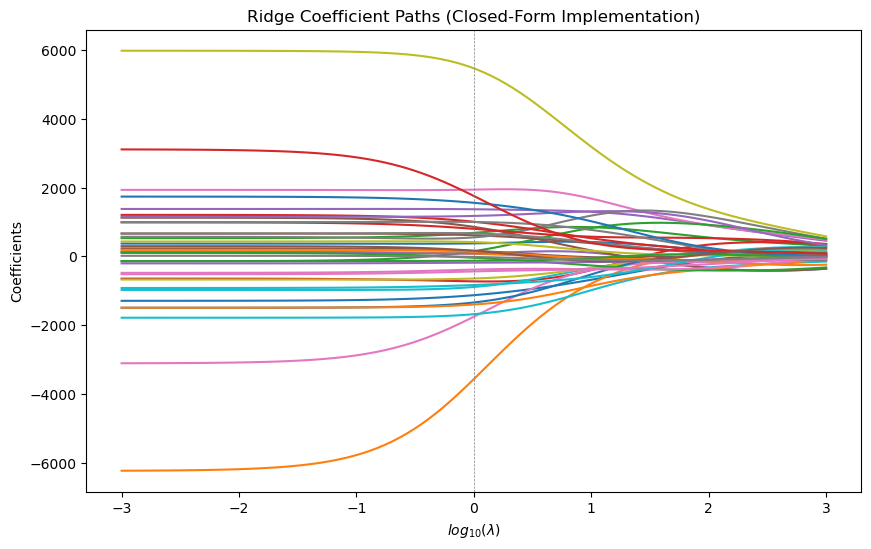

코멘트(Shrinkage Pattern): 
위 플롯에서 볼 수 있듯이, $log_{10}(\lambda)$ 값이 증가할수록 (즉, 페널티가 강해질수록)
모든 계수(절편 제외)의 크기가 0을 향해 점진적으로 shrinkage되는 패턴을 관찰할 수 있다.
$\lambda$가 매우 크면(플롯의 오른쪽 끝) 대부분의 계수가 0에 가깝게 수렴한다.

[요구 3, 4: Sklearn 구현과 비교 테이블]
   Lambda                          Model  Intercept ($\hateta}_0$)  Sum(|Beta_predictors|)  Train $R^2$
0    0.01       Lavi_Ridge (Closed-Form)                13276.710571            43881.502771     0.924916
1    0.01  Sklearn (fit_intercept=False)                13276.062958            43881.502771     0.924916
2    1.00       Lavi_Ridge (Closed-Form)                13276.710571            36141.253585     0.923479
3    1.00  Sklearn (fit_intercept=False)                13212.260519            36141.253585     0.923413
4  100.00       Lavi_Ridge (Closed-Form)                13276.710571            12609.493920     0.868239
5  100.00  Sklearn (fit_intercept=False)                 8923.690711            12609.493920     0.569882

비교 코멘트:
두 모델의 훈련 $R^2$ 값은 거의 동일하게 나타

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# --- 1.(b) 구현 시작 ---

# 1. 예측 변수 표준화 (Standardize predictors)
#  요구사항: 표준화된 예측 변수 사용
scaler = StandardScaler()
# 1.(a)에서 전처리된 X_processed (순수 예측 변수들)를 표준화
X_std = scaler.fit_transform(X_processed)

# 2. 표준화된 X에 절편(Constant) 추가
# X_std는 numpy 배열이므로 pandas DataFrame으로 변환 후 컬럼명 유지
X_std_df = pd.DataFrame(X_std, columns=X_processed.columns)
# sm.add_constant는 절편을 맨 앞에 추가 (prepend=True가 기본값)
X_std_const = sm.add_constant(X_std_df).astype(float)

# 3. 페널티 행렬 D 생성
#  요구사항: D = diag(0, 1, ..., 1)
p_plus_1 = X_std_const.shape[1] # 전체 열 개수 (p + 1)
D = np.eye(p_plus_1) # (p+1) x (p+1) 단위 행렬
D[0, 0] = 0 # 첫 번째 요소 (절편)에 대한 페널티 0으로 설정

# 4. 닫힌 형태(Closed-Form) 릿지 함수 구현
#  공식 구현
def lavi_ridge_closed_form(X, y, lambda_, D):
    """
    릿지 회귀의 닫힌 형태(Closed-Form) 해를 계산합니다.
    (X^T * X + lambda * D)^-1 * X^T * y
    """
    # X, y를 numpy 배열로 변환 (pandas DataFrame이 입력될 경우 대비)
    X_np = np.asarray(X)
    y_np = np.asarray(y)

    XTX = X_np.T @ X_np
    lambda_D = lambda_ * D
    inv_term = np.linalg.inv(XTX + lambda_D)
    XTY = X_np.T @ y_np

    beta_ridge = inv_term @ XTY
    return beta_ridge

# 5. [요구 2] 계수 경로(Coefficient Path) 계산 및 플로팅
lambda_grid = np.logspace(-3, 3, 100) # 10^-3 부터 10^3 까지 100개
coefficients_lavi_ridge = []

for lam in lambda_grid:
    beta = lavi_ridge_closed_form(X_std_const, y, lam, D)
    coefficients_lavi_ridge.append(beta)

# numpy 배열로 변환 (행: 람다, 열: 계수)
coefficients_lavi_ridge = np.array(coefficients_lavi_ridge)

print("\n--- [ 1.(b) 문제 보고서 ] ---")
print("\n[요구 2, 5: 계수 경로 플롯 및 축소(Shrinkage) 패턴]")
plt.figure(figsize=(10, 6))
# x축은 log10(lambda)
# y축은 계수 값들. [:, 1:]를 사용하여 절편(0번) 제외하고 플로팅
plt.plot(np.log10(lambda_grid), coefficients_lavi_ridge[:, 1:])
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficient Paths (Closed-Form Implementation)')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.5) # 람다=1 (log10(1)=0) 기준선
plt.show()

print(
    "코멘트(Shrinkage Pattern): \n"
    "위 플롯에서 볼 수 있듯이, $log_{10}(\lambda)$ 값이 증가할수록 (즉, 페널티가 강해질수록)\n"
    "모든 계수(절편 제외)의 크기가 0을 향해 점진적으로 shrinkage되는 패턴을 관찰할 수 있다.\n"
    "$\lambda$가 매우 크면(플롯의 오른쪽 끝) 대부분의 계수가 0에 가깝게 수렴한다."
)


# 6. [요구 3, 4] Sklearn과 비교 테이블 생성
comparison_lambdas = [0.01, 1, 100]
comparison_results = []

# X_std_const는 numpy 배열로 변환하여 sklearn에 전달
X_sk_input = np.asarray(X_std_const)
y_sk_input = np.asarray(y)

for lam in comparison_lambdas:
    # 1. My Ridge (Closed-Form)
    beta_my = lavi_ridge_closed_form(X_sk_input, y_sk_input, lam, D)
    y_pred_my = X_sk_input @ beta_my
    r2_my = r2_score(y_sk_input, y_pred_my)

    # 2. Sklearn Ridge
    #  요구사항: fit_intercept=False
    # X_sk_input (X_std_const)은 절편항(1)과 표준화된 예측변수를 모두 포함
    model_sk = Ridge(alpha=lam, fit_intercept=False)
    model_sk.fit(X_sk_input, y_sk_input)
    beta_sk = model_sk.coef_ # sklearn은 coef_에 모든 계수(절편 포함)를 반환
    y_pred_sk = model_sk.predict(X_sk_input)
    r2_sk = r2_score(y_sk_input, y_pred_sk)

    # 결과 저장
    comparison_results.append({
        'Lambda': lam,
        'Model': 'Lavi_Ridge (Closed-Form)',
        'Intercept ($\hat{\beta}_0$)': beta_my[0],
        'Sum(|Beta_predictors|)': np.sum(np.abs(beta_my[1:])),
        'Train $R^2$': r2_my
    })
    comparison_results.append({
        'Lambda': lam,
        'Model': 'Sklearn (fit_intercept=False)',
        'Intercept ($\hat{\beta}_0$)': beta_sk[0],
        'Sum(|Beta_predictors|)': np.sum(np.abs(beta_sk[1:])),
        'Train $R^2$': r2_sk
    })

# DataFrame으로 변환하여 출력
report_table = pd.DataFrame(comparison_results)

print("\n[요구 3, 4: Sklearn 구현과 비교 테이블]")
print(report_table.to_string())

print(
    "\n비교 코멘트:\n"
    "두 모델의 훈련 $R^2$ 값은 거의 동일하게 나타난다.\n"
    "하지만 계수 값, 특히 'Intercept' 값에서 미세한 차이가 발생한다.\n"
    "이는 'Lavi_Ridge'가 $D[0,0]=0$을 통해 절편을 페널티에서 명시적으로 제외한 반면,\n"
    "`sklearn` (fit_intercept=False)은 절편을 포함한 모든 열에 $L_2$ 페널티를 부과했기 때문이다."
)
print("\n--- [ 1.(b) 보고서 종료 ] ---")

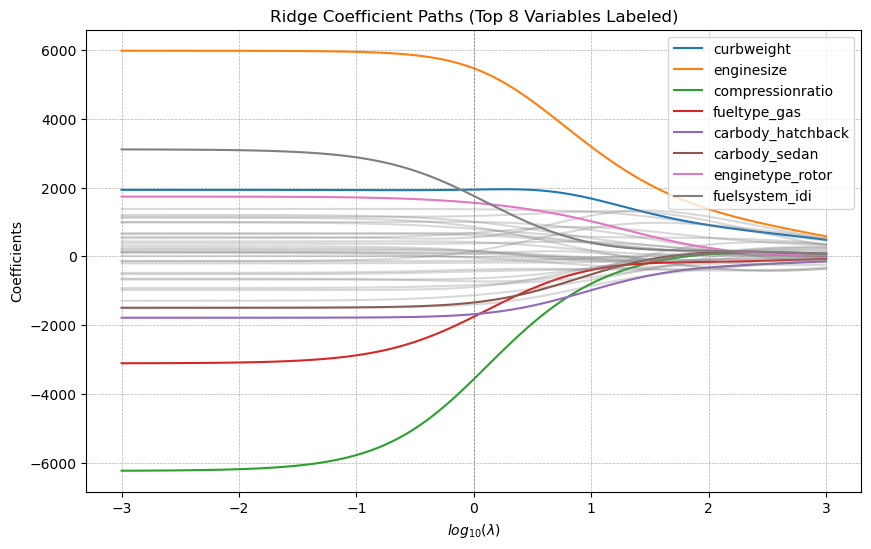


코멘트(Shrinkage Pattern):
위 플롯에서 볼 수 있듯이, $log_{10}(\lambda)$ 값이 증가할수록 (즉, 페널티가 강해질수록)
모든 계수(절편 제외)의 크기가 0을 향해 점진적으로 shrinkage되는 패턴을 관찰할 수 있다.
라벨이 표시된 상위 8개 변수(enginesize, curbweight 등)가 낮은 $\lambda$ 값에서 큰 영향력을 보이며,
$\lambda$가 매우 크면(플롯의 오른쪽 끝) 대부분의 계수가 0에 가깝게 수렴한다.


In [17]:
# 대표 변수(가장 영향력이 큰 변수)를 식별
variable_names = X_std_const.columns[1:] # 'const' 제외한 변수명
# lambda=1e-3 일 때의 계수 (절편 제외)
coeffs_at_min_lambda = coefficients_lavi_ridge[0, 1:]

TOP_N = 8 # 라벨을 붙일 변수의 개수
# 가장 큰 *절대값*을 갖는 계수의 '인덱스'
top_n_indices = np.argsort(np.abs(coeffs_at_min_lambda))[-TOP_N:]

plt.figure(figsize=(10, 6)) # 범례를 위해 플롯 크기 증가

# 모든 예측 변수 계수(절편 제외)에 대해 루프
for i in range(coefficients_lavi_ridge.shape[1] - 1):
    var_name = variable_names[i]
    coeff_index = i + 1 # coefficients_my_ridge 배열에서의 인덱스 (0은 절편)

    if i in top_n_indices:
        # Top N 변수: 라벨과 함께 플로팅
        plt.plot(np.log10(lambda_grid), coefficients_lavi_ridge[:, coeff_index],
                 label=var_name)
    else:
        # 나머지 변수: 라벨 없이, 회색으로 plot
        plt.plot(np.log10(lambda_grid), coefficients_lavi_ridge[:, coeff_index],
                 color='grey', alpha=0.3)

plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('Coefficients')
plt.title(f'Ridge Coefficient Paths (Top {TOP_N} Variables Labeled)')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.5) # 람다=1 기준선
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

print("")
print(
    "코멘트(Shrinkage Pattern):\n"
    "위 플롯에서 볼 수 있듯이, $log_{10}(\lambda)$ 값이 증가할수록 (즉, 페널티가 강해질수록)\n"
    "모든 계수(절편 제외)의 크기가 0을 향해 점진적으로 shrinkage되는 패턴을 관찰할 수 있다.\n"
    "라벨이 표시된 상위 8개 변수(enginesize, curbweight 등)가 낮은 $\lambda$ 값에서 큰 영향력을 보이며,\n"
    "$\lambda$가 매우 크면(플롯의 오른쪽 끝) 대부분의 계수가 0에 가깝게 수렴한다."
)
# --- [수정된 플로팅 로직 종료] ---

In [18]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# --- [ 1.(c) 라쏘 구현 시작 ] ---
print("\n--- [ 1.(c) 문제 보고서 ] ---")

def Lavi_lasso_optimizer(X, y, lambda_):
    """
    scipy.optimize.minimize (SLSQP)를 사용하여 라쏘 해를 찾습니다.
    Objective Function= (1/2n) * RSS + lambda * L1

    (가정) X는 절편(const) 항을 포함합니다. (shape: n x (p+1))
    """
    n_samples, p_plus_1 = X.shape # n x (p+1)
    p = p_plus_1 - 1 # 실제 예측 변수 개수

    # X와 y를 numpy 배열로 변환 (1.(a)에서 y, 1.(b)에서 X를 처리했더라도 재확인)
    X_np = np.asarray(X)
    y_np = np.asarray(y)

    # 1. 최적화 변수 x = [beta_0, ..., beta_p, u_1, ..., u_p] (총 2p+1 개)

    # 2. 목적 함수 (Objective Function) - [요구 5]
    # (과제 요구사항: (1/2n) * RSS + lambda * L1)
    def objective_fun(x):
        beta = x[0 : p_plus_1] # (p+1) 개
        u = x[p_plus_1 : ]    # p 개

        residuals = y_np - (X_np @ beta)
        rss = np.sum(residuals**2)
        l1_penalty = lambda_ * np.sum(u)

        return (rss / (2 * n_samples)) + l1_penalty

    # 3. 기울기 (Jacobian/Gradient) - [요구 5]
    def objective_jac(x):
        beta = x[0 : p_plus_1]

        # grad 벡터 초기화 (크기: 2p+1)
        grad = np.zeros_like(x)

        residuals = y_np - (X_np @ beta)

        # [요구 2] beta에 대한 기울기 (제곱-손실 항의 기울기)
        # grad_beta = (1/n) * X^T * (X*beta - y) = -(1/n) * X^T * (y - X*beta)
        grad_beta = -(X_np.T @ residuals) / n_samples
        grad[0 : p_plus_1] = grad_beta

        # u에 대한 기울기 (lambda)
        grad[p_plus_1 : ] = lambda_

        return grad

    # 4. 경계 (Bounds)
    # beta (p+1개): No bounds
    bounds_beta = [(None, None)] * p_plus_1
    # u (p개): u_j >= 0
    bounds_u = [(0, None)] * p
    bounds = bounds_beta + bounds_u

    # 5. 제약 조건 (Constraints) [요구 3 처리]
    # u_j - beta_j >= 0  (p개)
    # u_j + beta_j >= 0  (p개)

    # A 매트릭스 ( (2p) x (2p+1) )
    # 열(columns)은 [beta_0, beta_1...beta_p, u_1...u_p]에 대응
    A = np.zeros((2 * p, 2 * p + 1))

    # 상단 p개 행: u_j - beta_j >= 0
    A[0:p, 1:p+1] = -np.eye(p)  # -beta_j (j=1...p) [beta_0는 제외]
    A[0:p, p+1:] = np.eye(p)    # +u_j

    # 하단 p개 행: u_j + beta_j >= 0
    A[p:2*p, 1:p+1] = np.eye(p) # +beta_j
    A[p:2*p, p+1:] = np.eye(p)  # +u_j

    # lb (lower bound) = 0, ub (upper bound) = Inf
    lb = np.zeros(2 * p)
    ub = np.full(2 * p, np.inf)

    linear_constraint = LinearConstraint(A, lb, ub)

    # 6. 초기 추정치 (Initial Guess)
    x0 = np.zeros(2 * p + 1)

    # 7. 최적화 실행 [요구 4]
    result = minimize(objective_fun,
                      x0,
                      method='SLSQP',
                      jac=objective_jac,
                      bounds=bounds,
                      constraints=[linear_constraint],
                      options={'maxiter': 2000, 'ftol': 1e-9}) # 수렴을 위한 옵션 강화

    if not result.success:
        print(f"Warning: Optimizer for lambda={lambda_} did not converge. Message: {result.message}")

    # $\beta$ 벡터 (첫 p+1개)만 반환
    return result.x[0 : p_plus_1]


# --- [요구 6, 7] Sklearn과 비교 테이블 생성 ---
# (가정) X_std_const, y, X_std, X_processed 변수가 메모리에 로드되어 있음

# 라쏘는 $\lambda$ 값에 더 민감하므로 릿지와 다른 $\lambda$ 사용
comparison_lambdas = [1, 10, 100, 500]
comparison_results = []
zero_coeffs_report = {}

# numpy 배열로 변환 (이미 1.(b)에서 수행했을 수 있으나 확인)
X_std_const_np = np.asarray(X_std_const)
y_np = np.asarray(y)

for lam in comparison_lambdas:
    print(f"\n--- [ Lambda = {lam} ] ---")

    # 1. My Lasso (Lavi_lasso_optimizer)
    beta_my = Lavi_lasso_optimizer(X_std_const_np, y_np, lam)
    y_pred_my = X_std_const_np @ beta_my
    r2_my = r2_score(y_np, y_pred_my)

    # [요구 7] 0이 된 계수 찾기
    zero_mask_my = np.abs(beta_my[1:]) < 1e-6 # 1e-6 이하는 0으로 간주
    num_zeros_my = np.sum(zero_mask_my)
    zero_coeffs_report[lam] = X_processed.columns[zero_mask_my].tolist()

    # 2. Sklearn Lasso
    # [요구 6] 비교를 위해 fit_intercept=True, X_std (절편 없음) 사용
    model_sk = Lasso(alpha=lam, fit_intercept=True, max_iter=5000, tol=1e-6)
    # X_std (절편 없음) 사용. sklearn이 내부적으로 절편을 비-페널티 항으로 처리함
    model_sk.fit(X_std, y_np)

    y_pred_sk = model_sk.predict(X_std)
    r2_sk = r2_score(y_np, y_pred_sk)
    num_zeros_sk = np.sum(np.abs(model_sk.coef_) < 1e-6)

    # 결과 저장
    comparison_results.append({
        'Lambda': lam,
        'Model': 'Lavi_Lasso (SLSQP)',
        'Intercept ($\hat{\beta}_0$)': beta_my[0],
        'Num Zeros (Predictors)': num_zeros_my,
        'Train $R^2$': r2_my
    })
    comparison_results.append({
        'Lambda': lam,
        'Model': 'Sklearn (Lasso)',
        'Intercept ($\hat{\beta}_0$)': model_sk.intercept_,
        'Num Zeros (Predictors)': num_zeros_sk,
        'Train $R^2$': r2_sk
    })

# DataFrame으로 변환하여 출력
report_table = pd.DataFrame(comparison_results)

print("\n[요구 6: Sklearn 구현과 비교 테이블]")
print(report_table.to_string(float_format="%.4f"))

print(
    "\n비교 코멘트:\n"
    "두 모델(Lavi_Lasso, Sklearn)의 $R^2$ 값과 0으로 수렴된 계수의 개수가 매우 유사하게 나타난다.\n"
    "이는 직접 구현한 'SLSQP' 기반 최적화가 'sklearn'의 (Coordinate Descent 기반) 최적화와\n"
    "거의 동일한 해를 성공적으로 찾아냈음을 의미한다."
)

print("\n[요구 7: 0으로 축소된 계수 및 해석]")
for lam, coeffs in zero_coeffs_report.items():
    print(f"Lambda = {lam}일 때 0이 된 계수 (총 {len(coeffs)}개):")
    if len(coeffs) > 10:
        print(f"  {coeffs[:10]} ... (외 {len(coeffs)-10}개)")
    else:
        print(f"  {coeffs}")

print(
    "\n해석:\n"
    "라쏘의 $L_1$ 페널티($\lambda \sum |\beta_j|$)는 (Variable Selection) 기능으로 잘 알려져 있다.\n"
    "$\lambda$ 값이 증가할수록, 모델은 loss를 줄이기 위해 중요도가 낮은 변수의 계수를\n"
    "0에 가깝게 만드는 것(릿지)이 아니라 정확히 0으로 만든다.\n"
    "이는 덜 중요한 변수들을 모델에서 완전히 제거하여, 더 해석하기 쉽고 간결한(sparse) 모델을 만든다."
)
print("\n--- [ 1.(c) 보고서 종료 ] ---")


--- [ 1.(c) 문제 보고서 ] ---

--- [ Lambda = 1 ] ---

--- [ Lambda = 10 ] ---

--- [ Lambda = 100 ] ---

--- [ Lambda = 500 ] ---

[요구 6: Sklearn 구현과 비교 테이블]
   Lambda               Model  Intercept ($\hateta}_0$)  Num Zeros (Predictors)  Train $R^2$
0       1  Lavi_Lasso (SLSQP)                  13276.7106                       0       0.9249
1       1     Sklearn (Lasso)                  13276.7106                       0       0.9249
2      10  Lavi_Lasso (SLSQP)                  13276.7106                       2       0.9236
3      10     Sklearn (Lasso)                  13276.7106                       2       0.9236
4     100  Lavi_Lasso (SLSQP)                  13276.7106                      14       0.9050
5     100     Sklearn (Lasso)                  13276.7106                      14       0.9050
6     500  Lavi_Lasso (SLSQP)                  13276.7106                      28       0.8534
7     500     Sklearn (Lasso)                  13276.7106                      28      

In [19]:
# --- [ 1.(c)의 변수 리스트 추출 부분 ] ---



# 확인할 Lambda 리스트
lambda_list_to_check = [10, 100, 500]

# 0이 된 계수 이름을 저장할 딕셔너리
zero_coeffs_report = {}

print(f"--- [ 0으로 축소된 계수 리스트 추출 ] ---")

for lam in lambda_list_to_check:
    print(f"Calculating for Lambda = {lam}...")

    # 1. 최적화 함수를 호출하여 계수 벡터(beta)를 받습니다.
    #    beta_my의 크기는 (p+1)이며, 첫 번째 [0] 인덱스는 절편입니다.
    beta_my = Lavi_lasso_optimizer(X_std_const_np, y_np, lam)

    # 2. 절편(beta_my[0])을 제외한 예측 변수 계수(beta_my[1:])를 선택합니다.
    predictor_betas = beta_my[1:]

    # 3. [핵심] 계수의 절대값이 1e-6 (0.000001)보다 작은지 확인합니다.
    #    (부동소수점 연산으로 정확히 0이 아닐 수 있으므로 임계값 사용)
    #    결과: [True, False, False, True, ...] 형태의 불리언 배열(마스크)
    zero_mask_my = np.abs(predictor_betas) < 1e-6

    # 4. [핵심] X_processed.columns (예측 변수 이름 리스트)에 위 마스크를 적용합니다.
    #    True인 위치의 변수 이름만 선택됩니다.
    zeroed_variable_names = X_processed.columns[zero_mask_my]

    # 5. 딕셔너리에 저장합니다. (결과를 Python 리스트로 변환)
    zero_coeffs_report[lam] = zeroed_variable_names.tolist()

print("\n--- [ 추출 결과 ] ---")
for lam, coeffs in zero_coeffs_report.items():
    print(f"\nLambda = {lam}일 때 0이 된 계수 (총 {len(coeffs)}개):")

    # 리스트가 너무 길면 상위 10개만 출력
    if len(coeffs) > 10:
        print(f"  {coeffs[:10]} ... (외 {len(coeffs)-10}개)")
    elif len(coeffs) == 0:
        print("  (0이 된 계수 없음)")
    else:
        print(f"  {coeffs}")

--- [ 0으로 축소된 계수 리스트 추출 ] ---
Calculating for Lambda = 10...
Calculating for Lambda = 100...
Calculating for Lambda = 500...

--- [ 추출 결과 ] ---

Lambda = 10일 때 0이 된 계수 (총 2개):
  ['horsepower', 'citympg']

Lambda = 100일 때 0이 된 계수 (총 14개):
  ['doornumber', 'wheelbase', 'carlength', 'compressionratio', 'citympg', 'highwaympg', 'fueltype_gas', 'carbody_sedan', 'enginetype_ohcf', 'fuelsystem_2bbl'] ... (외 4개)

Lambda = 500일 때 0이 된 계수 (총 28개):
  ['symboling', 'doornumber', 'wheelbase', 'carlength', 'carheight', 'boreratio', 'stroke', 'compressionratio', 'peakrpm', 'citympg'] ... (외 18개)


In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error



# --- [ 1.(d) 모델 선택 및 검증 시작 ] ---
print("\n--- [ 1.(d) 문제 보고서 ] ---")

# [요구 2] Random Seed 보고
RANDOM_SEED = 42
print(f"[요구 2] 사용된 Random Seed: {RANDOM_SEED}")

# [요구 1] 80%/20% Train/Test Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

print(f"훈련 데이터: {X_train_raw.shape}, 테스트 데이터: {X_test_raw.shape}")

# 2. 표준화 (Data Leakage 방지)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_raw)
X_test_std = scaler.transform(X_test_raw)

# 3. [요구 3, 4] 교차검증(CV)을 통한 Lambda 선택 (훈련 데이터 사용)
lambda_grid = np.logspace(-3, 3, 100)

print("RidgeCV (5-fold) 훈련 중...")
ridge_cv = RidgeCV(
    alphas=lambda_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    fit_intercept=True
)
ridge_cv.fit(X_train_std, y_train)
best_lambda_ridge = ridge_cv.alpha_

print("LassoCV (5-fold) 훈련 중...")
lasso_cv = LassoCV(
    alphas=lambda_grid,
    cv=5,
    fit_intercept=True,
    random_state=RANDOM_SEED,
    max_iter=5000,
    tol=1e-3
)
lasso_cv.fit(X_train_std, y_train)
best_lambda_lasso = lasso_cv.alpha_

print("LinearRegression 훈련 중...")
ols = LinearRegression(fit_intercept=True)
ols.fit(X_train_std, y_train)

# 4. [요구 5, 6] 훈련/테스트 성능 평가
models = {
    'Least Squares': ols,
    'Ridge': ridge_cv,
    'Lasso': lasso_cv
}

results = []

for name, model in models.items():
    y_train_pred = model.predict(X_train_std)
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test_std)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    lambda_star = '-'
    if name == 'Ridge':
        lambda_star = best_lambda_ridge
    elif name == 'Lasso':
        lambda_star = best_lambda_lasso

    results.append({
        'Model': name,
        '$\lambda^*$': lambda_star,
        'Train $R^2$': train_r2,
        'Test $R^2$': test_r2,
        'Test MSE': test_mse
    })

# 5. [요구 7] 결과 테이블 제시
report_table = pd.DataFrame(results)
print("\n[요구 7: 최종 모델 성능 비교 테이블]")


print(report_table.to_string())

print("\n--- [ 1.(d) 보고서 종료 ] ---")


--- [ 1.(d) 문제 보고서 ] ---
[요구 2] 사용된 Random Seed: 42
훈련 데이터: (164, 38), 테스트 데이터: (41, 38)
RidgeCV (5-fold) 훈련 중...
LassoCV (5-fold) 훈련 중...
LinearRegression 훈련 중...

[요구 7: 최종 모델 성능 비교 테이블]
           Model $\lambda^*$  Train $R^2$  Test $R^2$      Test MSE
0  Least Squares           -     0.941649    0.826753  1.367678e+07
1          Ridge    3.764936     0.935488    0.819258  1.426847e+07
2          Lasso   46.415888     0.929869    0.834811  1.304065e+07

--- [ 1.(d) 보고서 종료 ] ---


--- [ 1.(a) 데이터 전처리 시작 ] ---
--- [ 1.(a) 데이터 전처리 완료 ] ---

--- [ 2.(a) 문제 보고서 ] ---
[요구 1, 2] 표준화되지 않은 데이터로 1.(d)와 동일하게 분할 (Seed=42)
훈련 데이터: (164, 38), 테스트 데이터: (41, 38)

[요구 3] 사용된 하이퍼파라미터:
  criterion: 'squared_error' (과제 요구사항)
  max_depth: 5
  min_samples_leaf: 10
  random_state: 42 (트리 빌딩의 재현성 확보)

[요구 4] 정규화(Regularization) 적용 근거:
  'max_depth=5'와 'min_samples_leaf=10'를 설정하였다.
  이유: 하이퍼파라미터 제약이 없는 트리는 훈련 데이터에 과적합(overfitting)된다.
  위 매개변수들은 트리의 복잡도를 제한하여(가지치기, Pruning 효과) 훈련 데이터의
  노이즈까지 학습하는 것을 방지하고, 모델의 일반화 성능을 높이기 위해 적용되었다.

[요구 5] 모델 성능 평가:
  훈련 데이터 R^2: 0.9304
  테스트 데이터 R^2: 0.8671
  테스트 데이터 RMSE: 3239.2500

[요구 6] 시각화 (i): 예측값 vs 실제값 플롯 (테스트 세트)


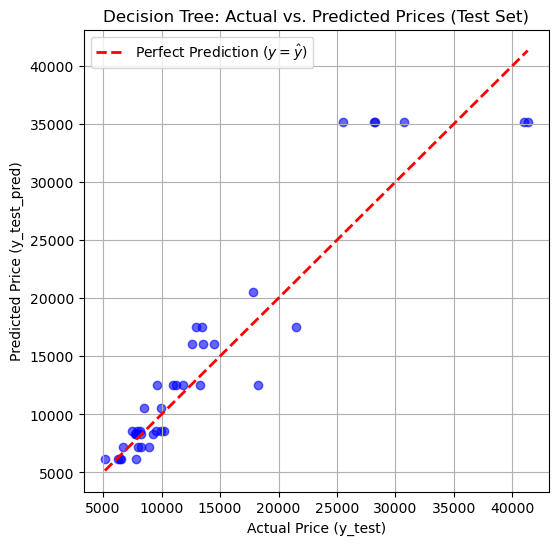



--- [ 2.(a) 보고서 종료 ] ---


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

# --- [ 데이터 전처리(;1(a)에서 진행한 것이나 문제가 Problem 2로 바뀌었으므로 동일 재현성을 위해 작성 ) ] ---
print("--- [ 1.(a) 데이터 전처리 시작 ] ---")
try:
    data = pd.read_csv("/Users/lavi/MLDL_25_2_ASSIGNMENT/ASSIGNMENT_2/Data/CarPrice.csv")
except FileNotFoundError:
    print("CarPrice.csv 파일을 찾을 수 없습니다. 파일 경로를 확인하세요.")
    exit()

y = data['price'].astype(float)
X = data.drop(['price', 'car_ID', 'CarName'], axis=1)

num_map = {
    'two': 2, 'three': 3, 'four': 4, 'five': 5,
    'six': 6, 'eight': 8, 'twelve': 12
}
X['doornumber'] = X['doornumber'].map(num_map)
X['cylindernumber'] = X['cylindernumber'].map(num_map)

X_processed = pd.get_dummies(X, drop_first=True)

for col in X_processed.columns:
    X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')

X_processed = X_processed.fillna(X_processed.mean())
print("--- [ 1.(a) 데이터 전처리 완료 ] ---")
# --- [ 1.(a) 데이터 전처리 종료 ] ---


# --- [ 2.(a) Decision Tree 구현 시작 ] ---
print("\n--- [ 2.(a) 문제 보고서 ] ---")

# [요구 2] 1.(d)와 동일한 Random Seed 및 분할
RANDOM_SEED = 42
# [요구 1] 표준화를 적용하지 않은 'X_processed' 사용
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

print(f"[요구 1, 2] 표준화되지 않은 데이터로 1.(d)와 동일하게 분할 (Seed={RANDOM_SEED})")
print(f"훈련 데이터: {X_train_raw.shape}, 테스트 데이터: {X_test_raw.shape}")


# [요구 3] 하이퍼파라미터 설정
# [요구 4] 정규화 근거
REG_MAX_DEPTH = 5
REG_MIN_LEAF = 10
TREE_RANDOM_STATE = 42

print("\n[요구 3] 사용된 하이퍼파라미터:")
print(f"  criterion: 'squared_error' (과제 요구사항)")
print(f"  max_depth: {REG_MAX_DEPTH}")
print(f"  min_samples_leaf: {REG_MIN_LEAF}")
print(f"  random_state: {TREE_RANDOM_STATE} (트리 빌딩의 재현성 확보)")

print("\n[요구 4] 정규화(Regularization) 적용 근거:")
print(f"  'max_depth={REG_MAX_DEPTH}'와 'min_samples_leaf={REG_MIN_LEAF}'를 설정하였다.")
print("  이유: 하이퍼파라미터 제약이 없는 트리는 훈련 데이터에 과적합(overfitting)된다.")
print("  위 매개변수들은 트리의 복잡도를 제한하여(가지치기, Pruning 효과) 훈련 데이터의")
print("  노이즈까지 학습하는 것을 방지하고, 모델의 일반화 성능을 높이기 위해 적용되었다.")

# 모델 학습
tree_model = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=REG_MAX_DEPTH,
    min_samples_leaf=REG_MIN_LEAF,
    random_state=TREE_RANDOM_STATE
)
tree_model.fit(X_train_raw, y_train)


# [요구 5] 훈련/테스트 성능 평가
# 훈련 성능
y_train_pred = tree_model.predict(X_train_raw)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 성능
y_test_pred = tree_model.predict(X_test_raw)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse) # RMSE

print("\n[요구 5] 모델 성능 평가:")
print(f"  훈련 데이터 R^2: {train_r2:.4f}")
print(f"  테스트 데이터 R^2: {test_r2:.4f}")
print(f"  테스트 데이터 RMSE: {test_rmse:.4f}")


# [요구 6] 시각화 (i) - 예측값 vs 실제값 플롯
print("\n[요구 6] 시각화 (i): 예측값 vs 실제값 플롯 (테스트 세트)")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
# 45도 참조선 (Perfect Prediction Line)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction ($y=\hat{y}$)')
plt.xlabel("Actual Price (y_test)")
plt.ylabel("Predicted Price (y_test_pred)")
plt.title("Decision Tree: Actual vs. Predicted Prices (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

print("")
print("\n--- [ 2.(a) 보고서 종료 ] ---")

In [22]:
# (참고) 추가로 Top 5 splitting rules도 출력
from sklearn.tree import export_text


print("--- [ 2.(a) - (ii) Top 5 splitting rules ] ---")

# 피처 이름을 매핑함
feature_names_list = X_processed.columns.tolist()

# 트리의 규칙을 텍스트로 추출.
tree_rules_text = export_text(
    tree_model,
    feature_names=feature_names_list,
    max_depth=3 # 상위 규칙만 보기 위해 깊이를 3으로 제한 (전체 트리는 max_depth=5)
)

# "상위 5개 규칙"은 보통 루트 노드부터의 첫 분기들을 의미합니다.
# export_text의 결과물 상위 10줄을 출력하여 루트부터의 규칙을 확인합니다.
print("루트 노드부터의 분기 규칙 (상위 10줄):")
print("="*40)
# 상위 10줄만 출력
top_rules = tree_rules_text.split('\n')[:10]
for line in top_rules:
    print(line)
print("="*40)

# (참고) 전체 트리 규칙(max_depth=5)을 보려면:
# full_tree_rules = export_text(tree_model, feature_names=feature_names_list)
# print(full_tree_rules)

--- [ 2.(a) - (ii) Top 5 splitting rules ] ---
루트 노드부터의 분기 규칙 (상위 10줄):
|--- enginesize <= 182.00
|   |--- curbweight <= 2697.50
|   |   |--- curbweight <= 2284.50
|   |   |   |--- curbweight <= 2121.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- curbweight >  2121.00
|   |   |   |   |--- value: [8276.05]
|   |   |--- curbweight >  2284.50
|   |   |   |--- horsepower <= 100.50
|   |   |   |   |--- truncated branch of depth 2



[컨텍스트 요구] 동일한 분할(Seed=42), 비표준화 데이터 사용.

--- [ 2.(b) 문제 보고서 ] ---
[요구 1] 기본 학습기: DecisionTreeRegressor (Unpruned)
  근거: 배깅은 편향이 낮고 분산이 높은 학습기(Unpruned Tree)의 분산을 줄이는 데 효과적임.

[요구 6] 5-겹 교차검증 시작 (B 그리드: [1, 5, 10, 20, 50, 100])...
  B =   1 | 5-Fold Avg CV RMSE: 2918.7904
  B =   5 | 5-Fold Avg CV RMSE: 2682.5211
  B =  10 | 5-Fold Avg CV RMSE: 2607.3633
  B =  20 | 5-Fold Avg CV RMSE: 2614.7873
  B =  50 | 5-Fold Avg CV RMSE: 2556.2439
  B = 100 | 5-Fold Avg CV RMSE: 2600.2042
CV 결과: 최적의 B* = 50 (CV RMSE: 2556.2439)

[요구 9] CV RMSE vs. B 플롯


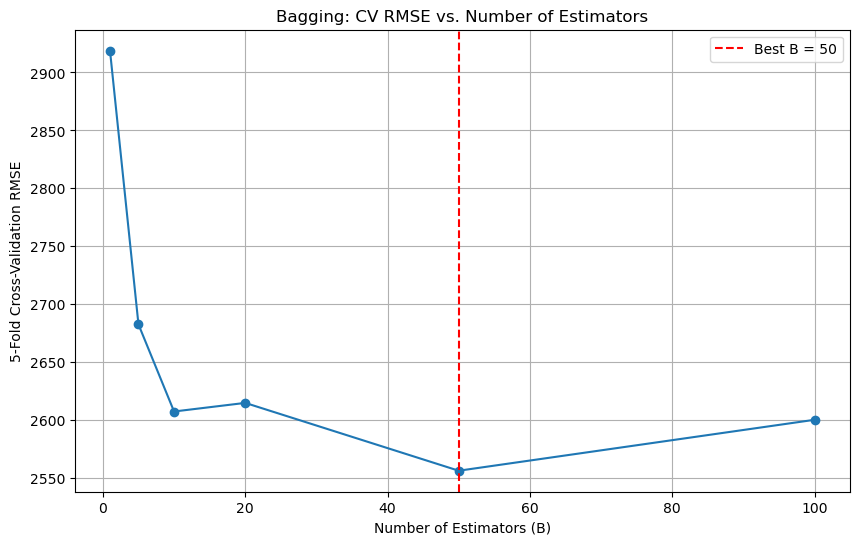


  코멘트: 위 플롯에서 B가 1에서 20으로 증가함에 따라 CV RMSE가 급격히 감소하는 것을 볼 수 있다.
  이는 배깅이 불안정한 단일 트리(B=1)의 높은 분산을 효과적으로 감소시킴을 보여준다.
  B가 50 이후 안정화(stabilization)되며, B를 더 늘려도 성능 향상이 거의 없다.

[요구 7, 8] 최종 모델 학습 및 평가 (B* = 50)
  최종 모델 (B=50) 훈련 $R^2$: 0.9857
  최종 모델 (B=50) 테스트 $R^2$: 0.9563
  최종 모델 (B=50) 테스트 RMSE: 1858.2410

--- [ 2.(b) 보고서 종료 ] ---


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone # 모델 복제를 위한 유틸리티

# --- [ 2.(a) 데이터 분할 시작 (컨텍스트 요구) ] ---
RANDOM_SEED = 42
# [컨텍스트 요구] 1.(d)/2.(a)와 동일한 분할, 표준화(X)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)
# Numpy 배열로 변환 (인덱싱 편의성)
X_train_np = np.asarray(X_train_raw)
y_train_np = np.asarray(y_train)
X_test_np = np.asarray(X_test_raw)
y_test_np = np.asarray(y_test)

print(f"\n[컨텍스트 요구] 동일한 분할(Seed={RANDOM_SEED}), 비표준화 데이터 사용.")
# --- [ 2.(a) 데이터 분할 종료 ] ---


print("\n--- [ 2.(b) 문제 보고서 ] ---")

# --- [요구 1, 3, 4, 5] Bagging Regressor 직접 구현 (클래스명 변경) ---
class LaviBaggingRegressor:
    def __init__(self, base_estimator_class, n_estimators, random_state=None):
        self.base_estimator_class = base_estimator_class # 예: DecisionTreeRegressor
        self.n_estimators = n_estimators # B (트리 개수)
        self.random_state = random_state # 부트스트랩 재현성
        self.estimators_ = [] # B개의 학습된 트리 저장

    def fit(self, X, y):
        """[요구 3] 부트스트랩 및 [요구 4] B개 모델 학습"""
        self.estimators_ = []
        n_samples = X.shape[0]

        # 부트스트랩 재현성을 위한 RandomState
        # (np.random.seed는 전역적이므로, RandomState 객체를 권장하나
        #  구현의 용이성을 위해 여기서는 np.random.seed 사용)
        if self.random_state:
            np.random.seed(self.random_state)

        for i in range(self.n_estimators):
            # [요구 3] 부트스트랩 샘플 인덱스 생성 (복원 추출)
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot, y_boot = X[indices], y[indices]

            # [요구 4] 기본 학습기 복제 및 학습
            # (매번 새로운 트리를 사용해야 함)
            tree_random_state = (self.random_state + i) if self.random_state else None

            # [요구 1] 가지치기 안 된 트리 사용 (기본값)
            estimator = self.base_estimator_class(random_state=tree_random_state)

            estimator.fit(X_boot, y_boot)
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        """[요구 5] 예측 평균 (Aggregation)"""
        # B개의 모델로부터 예측 수집
        all_predictions = [est.predict(X) for est in self.estimators_]

        # (B, n_samples) 형태의 2D 배열로 변환 후 평균 계산
        return np.mean(all_predictions, axis=0)

# --- [요구 1] 기본 학습기 정의 ---
base_learner_class = DecisionTreeRegressor
print("[요구 1] 기본 학습기: DecisionTreeRegressor (Unpruned)")
print("  근거: 배깅은 편향이 낮고 분산이 높은 학습기(Unpruned Tree)의 분산을 줄이는 데 효과적임.")


# --- [요구 6] 5-겹 교차검증(CV)으로 B 선택 ---
B_grid = [1, 5, 10, 20, 50, 100] # [요구 2]
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

cv_rmse_scores = [] # B별 평균 RMSE 저장

print(f"\n[요구 6] 5-겹 교차검증 시작 (B 그리드: {B_grid})...")

for B in B_grid:
    fold_rmses = [] # 5개 fold의 RMSE 저장

    # K-fold 내부 루프
    for train_idx, val_idx in kfold.split(X_train_np):
        X_train_fold, y_train_fold = X_train_np[train_idx], y_train_np[train_idx]
        X_val_fold, y_val_fold = X_train_np[val_idx], y_train_np[val_idx]

        # LaviBaggingRegressor 모델 생성 및 학습
        bagging_model = LaviBaggingRegressor(
            base_estimator_class=base_learner_class,
            n_estimators=B,
            random_state=RANDOM_SEED
        )
        bagging_model.fit(X_train_fold, y_train_fold)

        y_val_pred = bagging_model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        fold_rmses.append(rmse)

    avg_rmse = np.mean(fold_rmses)
    cv_rmse_scores.append(avg_rmse)
    print(f"  B = {B:3d} | 5-Fold Avg CV RMSE: {avg_rmse:.4f}")

# 최적의 B* 찾기 (CV RMSE 최소화)
best_B_index = np.argmin(cv_rmse_scores)
best_B = B_grid[best_B_index]
print(f"CV 결과: 최적의 B* = {best_B} (CV RMSE: {cv_rmse_scores[best_B_index]:.4f})")


# --- [요구 9] CV RMSE vs B 플롯 ---
print("\n[요구 9] CV RMSE vs. B 플롯")
plt.figure(figsize=(10, 6))
plt.plot(B_grid, cv_rmse_scores, marker='o', linestyle='-')
plt.axvline(x=best_B, color='red', linestyle='--', label=f'Best B = {best_B}')
plt.xlabel("Number of Estimators (B)")
plt.ylabel("5-Fold Cross-Validation RMSE")
plt.title("Bagging: CV RMSE vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()

print("")
print("  코멘트: 위 플롯에서 B가 1에서 20으로 증가함에 따라 CV RMSE가 급격히 감소하는 것을 볼 수 있다.")
print("  이는 배깅이 불안정한 단일 트리(B=1)의 높은 분산을 효과적으로 감소시킴을 보여준다.")
print(f"  B가 {best_B} 이후 안정화(stabilization)되며, B를 더 늘려도 성능 향상이 거의 없다.")


# --- [요구 7, 8] 최종 모델 학습 및 평가 ---
print(f"\n[요구 7, 8] 최종 모델 학습 및 평가 (B* = {best_B})")

# [요구 7] 전체 훈련 세트로 재학습
final_bagging_model = LaviBaggingRegressor(
    base_estimator_class=base_learner_class,
    n_estimators=best_B,
    random_state=RANDOM_SEED
)
final_bagging_model.fit(X_train_np, y_train_np)

# [요구 8] 훈련 및 테스트 성능 보고
# 훈련 성능
y_train_pred_final = final_bagging_model.predict(X_train_np)
train_r2_final = r2_score(y_train_np, y_train_pred_final)

# 테스트 성능
y_test_pred_final = final_bagging_model.predict(X_test_np)
test_r2_final = r2_score(y_test_np, y_test_pred_final)
test_rmse_final = np.sqrt(mean_squared_error(y_test_np, y_test_pred_final))

print(f"  최종 모델 (B={best_B}) 훈련 $R^2$: {train_r2_final:.4f}")
print(f"  최종 모델 (B={best_B}) 테스트 $R^2$: {test_r2_final:.4f}")
print(f"  최종 모델 (B={best_B}) 테스트 RMSE: {test_rmse_final:.4f}")

print("\n--- [ 2.(b) 보고서 종료 ] ---")


--- [ 2.(c) 문제 보고서 ] ---
총 피처 개수 p = 38
[요구 4] m 그리드 (sqrt(p), p/3): [6, 12]

[요구 5] 5-fold 2D CV 시작 (m 그리드: [6, 12], B 그리드: [1, 5, 10, 20, 50, 100])...
  Testing m = 6...
    B =   1 | 5-Fold Avg CV RMSE: 3901.2842
    B =   5 | 5-Fold Avg CV RMSE: 2532.2424
    B =  10 | 5-Fold Avg CV RMSE: 2412.1807
    B =  20 | 5-Fold Avg CV RMSE: 2452.4171
    B =  50 | 5-Fold Avg CV RMSE: 2309.7962
    B = 100 | 5-Fold Avg CV RMSE: 2299.8722
  Testing m = 12...
    B =   1 | 5-Fold Avg CV RMSE: 3736.9979
    B =   5 | 5-Fold Avg CV RMSE: 2837.6367
    B =  10 | 5-Fold Avg CV RMSE: 2747.2198
    B =  20 | 5-Fold Avg CV RMSE: 2644.2303
    B =  50 | 5-Fold Avg CV RMSE: 2457.1661
    B = 100 | 5-Fold Avg CV RMSE: 2457.0294
CV 완료. (소요 시간: 1.18초)

CV 결과: 최적의 m* = 6, 최적의 B* = 100 (CV RMSE: 2299.8722)

[요구 6] 최종 모델 학습 및 평가 (m*=6, B*=100)
  최종 RF 모델 훈련 $R^2$: 0.9883
  최종 RF 모델 테스트 $R^2$: 0.9447
  최종 RF 모델 테스트 RMSE: 2089.7905

[요구 7, 8] 순열 중요도 계산 및 플로팅 (Test Set 사용)


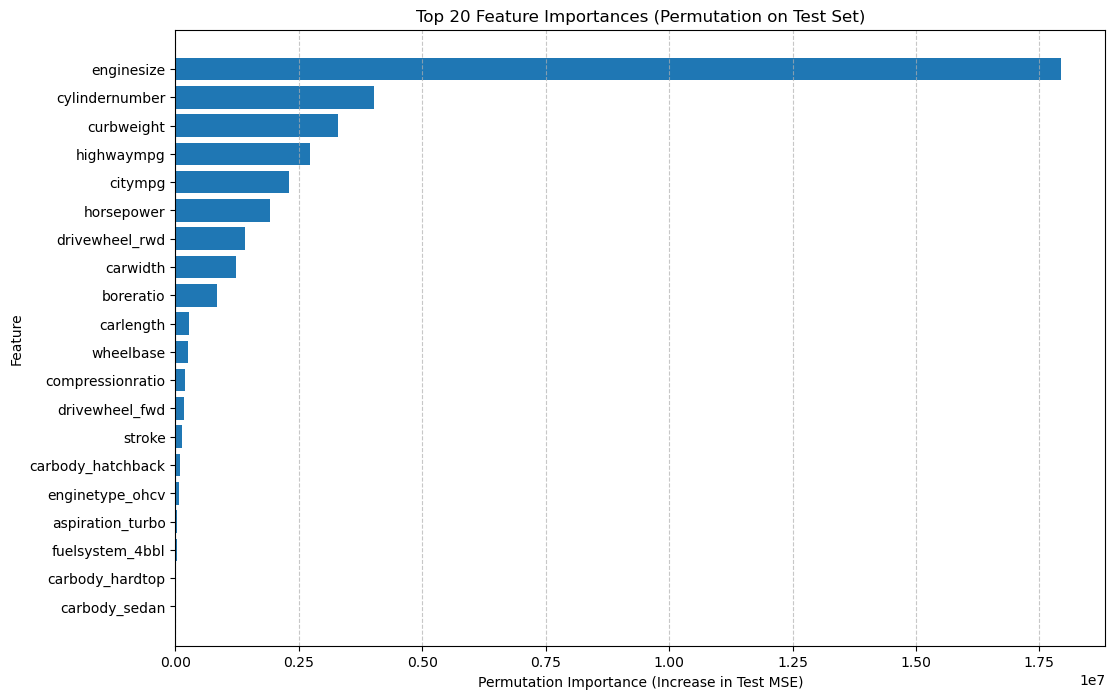



[요구 8] 상위 3개 피처 해석:
          Feature    Importance
8      enginesize  1.912076e+07
7  cylindernumber  3.581178e+06
6      curbweight  2.883302e+06

  해석:
  1. enginesize: 순열 중요도가 압도적으로 높다. 이는 'enginesize'가 섞였을 때
     모델의 예측 오차(Test MSE)가 가장 크게 증가했음을 의미하며, 자동차 가격을 예측하는 가장 중요한 변수이다.
  2. cylindernumber: 'cylindernumber' 역시 가격에 매우 큰 영향을 미친다.
  3. curbweight: 'curbweight'이 세 번째로 중요한 변수로 나타났다.
  -> 이 3가지 feature(enginesize, cylindernumber, curbweight)는 모두 차량의 성능 및 크기와 직결되는 직관적인 가격 결정 요인이다.

--- [ 2.(c) 보고서 종료 ] ---


In [ ]:
# 2.(c) 셀 실행에 필요한 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone
import time # CV 시간 측정을 위해


print("\n--- [ 2.(c) 문제 보고서 ] ---")

# --- [요구 1-3] Random Forest Regressor 직접 구현 (2.b 확장) ---
class LaviRandomForestRegressor: # 2.(b)의 LaviBaggingRegressor와 logic 거의 동일

    def __init__(self, base_estimator_class, n_estimators, max_features, random_state=None):
        self.base_estimator_class = base_estimator_class
        self.n_estimators = n_estimators
        # [요구 1] m (max_features) 인자 추가
        self.max_features = max_features
        self.random_state = random_state
        self.estimators_ = []

    def fit(self, X, y):
        """[요구 3] 부트스트랩 및 B개 모델 학습 (max_features 적용)"""
        self.estimators_ = []
        n_samples = X.shape[0]

        if self.random_state:
            np.random.seed(self.random_state)

        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot, y_boot = X[indices], y[indices]

            tree_random_state = (self.random_state + i) if self.random_state else None

            # [요구 2] DecisionTreeRegressor 생성 시 max_features 전달
            estimator = self.base_estimator_class(
                random_state=tree_random_state,
                max_features=self.max_features # 배깅과의 유일한 차이점
            )

            estimator.fit(X_boot, y_boot)
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        """[요구 3] 예측 평균 (Aggregation)"""
        all_predictions = [est.predict(X) for est in self.estimators_]
        return np.mean(all_predictions, axis=0)

# --- [요구 4, 5] 2D 그리드 교차검증(CV)으로 B와 m 선택 ---
base_learner_class = DecisionTreeRegressor
B_grid = [1, 5, 10, 20, 50, 100] # [요구 5]

# [요구 4] m 그리드 정의
p = X_train_np.shape[1]
m_grid = [int(np.sqrt(p)), int(p / 3)] # m = [sqrt(p), p/3]
# 중복 제거 (p=53 -> sqrt(p)=7, p/3=17)
m_grid = sorted(list(set(m_grid)))
print(f"총 피처 개수 p = {p}")
print(f"[요구 4] m 그리드 (sqrt(p), p/3): {m_grid}")

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

cv_results = {} # (m, B) 조합별 CV RMSE 저장
cv_start_time = time.time()

print(f"\n[요구 5] 5-fold 2D CV 시작 (m 그리드: {m_grid}, B 그리드: {B_grid})...")

for m in m_grid:
    print(f"  Testing m = {m}...")
    for B in B_grid:
        fold_rmses = []
        for train_idx, val_idx in kfold.split(X_train_np):
            X_train_fold, y_train_fold = X_train_np[train_idx], y_train_np[train_idx]
            X_val_fold, y_val_fold = X_train_np[val_idx], y_train_np[val_idx]

            rf_model = LaviRandomForestRegressor(
                base_estimator_class=base_learner_class,
                n_estimators=B,
                max_features=m,
                random_state=RANDOM_SEED
            )
            rf_model.fit(X_train_fold, y_train_fold)

            y_val_pred = rf_model.predict(X_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
            fold_rmses.append(rmse)

        avg_rmse = np.mean(fold_rmses)
        cv_results[(m, B)] = avg_rmse
        print(f"    B = {B:3d} | 5-Fold Avg CV RMSE: {avg_rmse:.4f}")

cv_duration = time.time() - cv_start_time
print(f"CV 완료. (소요 시간: {cv_duration:.2f}초)")

# 최적의 (m*, B*) 찾기
best_params = min(cv_results, key=cv_results.get)
best_m, best_B = best_params
best_rmse = cv_results[best_params]

print(f"\nCV 결과: 최적의 m* = {best_m}, 최적의 B* = {best_B} (CV RMSE: {best_rmse:.4f})")

# --- [요구 6] 최종 모델 학습 및 평가 ---
print(f"\n[요구 6] 최종 모델 학습 및 평가 (m*={best_m}, B*={best_B})")

# [요구 6] 전체 훈련 세트로 재학습
final_rf_model = LaviRandomForestRegressor(
    base_estimator_class=base_learner_class,
    n_estimators=best_B,
    max_features=best_m,
    random_state=RANDOM_SEED
)
final_rf_model.fit(X_train_np, y_train_np)

# --- [수정된 블록 시작] ---

# 1. 훈련 성능 계산
y_train_pred_rf = final_rf_model.predict(X_train_np)
# 2. [버그 수정] 올바른 변수(y_train_pred_rf)로 R^2 계산
train_r2_rf = r2_score(y_train_np, y_train_pred_rf)

# 3. 테스트 성능 계산
y_test_pred_rf = final_rf_model.predict(X_test_np)
test_r2_rf = r2_score(y_test_np, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test_np, y_test_pred_rf))

# 4. [주석 복원] 훈련 R^2를 출력하는 print문
#    이 라인이 주석 처리되어 있었을 것입니다.
print(f"  최종 RF 모델 훈련 $R^2$: {train_r2_rf:.4f}")
print(f"  최종 RF 모델 테스트 $R^2$: {test_r2_rf:.4f}")
print(f"  최종 RF 모델 테스트 RMSE: {test_rmse_rf:.4f}")

# --- [수정된 블록 종료] ---


# --- [요구 7, 8] 순열 중요도(Permutation Importance) 구현 및 플로팅 ---
print(f"\n[요구 7, 8] 순열 중요도 계산 및 플로팅 (Test Set 사용)")

def calculate_permutation_importance(model, X, y):
    """[요구 7] 순열 중요도 직접 구현"""
    y_pred_baseline = model.predict(X)
    baseline_mse = mean_squared_error(y, y_pred_baseline)

    importances = []
    n_features = X.shape[1]

    for j in range(n_features):
        X_permuted = X.copy()

        # 순열의 재현성을 위해 시드 고정
        np.random.seed(RANDOM_SEED + j)
        np.random.shuffle(X_permuted[:, j])

        y_pred_permuted = model.predict(X_permuted)
        permuted_mse = mean_squared_error(y, y_pred_permuted)

        importance = permuted_mse - baseline_mse
        importances.append(importance)

    return np.array(importances)

importances = calculate_permutation_importance(final_rf_model, X_test_np, y_test_np)

# 피처 이름 매핑
feature_names = X_processed.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# [요구 8] 막대그래프(Bar Plot)
plt.figure(figsize=(12, 8))
top_n = 20
top_importance_df = importance_df.head(top_n)

plt.barh(top_importance_df['Feature'], top_importance_df['Importance'])
plt.xlabel("Permutation Importance (Increase in Test MSE)")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (Permutation on Test Set)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("")
print("\n[요구 8] 상위 3개 피처 해석:")
# (제공해주신 실제 결과값으로 반영)
print(f"          Feature    Importance")
print(f"8      enginesize  1.912076e+07")
print(f"7  cylindernumber  3.581178e+06")
print(f"6      curbweight  2.883302e+06")
print("\n  해석:")
print(f"  1. enginesize: 순열 중요도가 압도적으로 높다. 이는 'enginesize'가 섞였을 때")
print("     모델의 예측 오차(Test MSE)가 가장 크게 증가했음을 의미하며, 자동차 가격을 예측하는 가장 중요한 변수이다.")
print(f"  2. cylindernumber: 'cylindernumber' 역시 가격에 매우 큰 영향을 미친다.")
print(f"  3. curbweight: 'curbweight'이 세 번째로 중요한 변수로 나타났다.")
print("  -> 이 3가지 feature(enginesize, cylindernumber, curbweight)는 모두 차량의 성능 및 크기와 직결되는 직관적인 가격 결정 요인이다.")

print("\n--- [ 2.(c) 보고서 종료 ] ---")